# Imports

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import cftime
import xarray as xr
import glob
import matplotlib.dates as mdates
from scipy import stats
from scipy.stats import ks_2samp
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import random
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os
import geopandas as gpd
import regionmask
import calendar
from xclim import sdba

region_str = 'northeastern_US'
model_list = ['ACCESS-CM2', 'ACCESS-ESM1-5', 'AWI-CM-1-1-MR', 'BCC-CSM2-MR',
       'CAMS-CSM1-0', 'CESM2', 'CESM2-WACCM', 'CMCC-CM2-SR5', 'CMCC-ESM2',
       'CNRM-CM6-1', 'CNRM-CM6-1-HR', 'CNRM-ESM2-1', 'CanESM5',
       'EC-Earth3', 'EC-Earth3-CC', 'EC-Earth3-Veg', 'EC-Earth3-Veg-LR',
       'FGOALS-g3', 'GFDL-CM4', 'GFDL-ESM4', 'HadGEM3-GC31-LL',
       'IITM-ESM', 'INM-CM4-8', 'INM-CM5-0', 'IPSL-CM6A-LR', 'KACE-1-0-G',
       'KIOST-ESM', 'MIROC-ES2L', 'MIROC6', 'MPI-ESM1-2-HR',
       'MPI-ESM1-2-LR', 'MRI-ESM2-0', 'NESM3', 'NorESM2-LM', 'NorESM2-MM',
       'TaiESM1', 'UKESM1-0-LL']

variant_list = {'ACCESS-CM2': ['r1i1p1f1'],'ACCESS-ESM1-5': ['r1i1p1f1'],'AWI-CM-1-1-MR': ['r1i1p1f1'],'BCC-CSM2-MR': ['r1i1p1f1'],
                'CAMS-CSM1-0': ['r2i1p1f1'],'CESM2': ['r4i1p1f1'],'CESM2-WACCM': ['r1i1p1f1'],'CMCC-CM2-SR5': ['r1i1p1f1'],'CMCC-ESM2': ['r1i1p1f1'],
                'CNRM-CM6-1': ['r1i1p1f2'],'CNRM-CM6-1-HR': ['r1i1p1f2'],'CNRM-ESM2-1': ['r1i1p1f2'],'CanESM5': ['r1i1p1f1'],
                'EC-Earth3': ['r1i1p1f1'],'EC-Earth3-CC': ['r1i1p1f1'],'EC-Earth3-Veg': ['r1i1p1f1'],'EC-Earth3-Veg-LR': ['r1i1p1f1'],
                'FGOALS-g3': ['r1i1p1f1'],'GFDL-CM4': ['r1i1p1f1'],'GFDL-ESM4': ['r1i1p1f1'],'HadGEM3-GC31-LL': ['r1i1p1f3'],
                'IITM-ESM': ['r1i1p1f1'],'INM-CM4-8': ['r1i1p1f1'],'INM-CM5-0': ['r1i1p1f1'],'IPSL-CM6A-LR': ['r1i1p1f1'],
                'KACE-1-0-G': ['r1i1p1f1'],'KIOST-ESM': ['r1i1p1f1'],'MIROC-ES2L': ['r1i1p1f2'],'MIROC6': ['r1i1p1f1'],
                'MPI-ESM1-2-HR': ['r1i1p1f1'],'MPI-ESM1-2-LR': ['r1i1p1f1'],'MRI-ESM2-0': ['r1i1p1f1'],
                'NESM3': ['r1i1p1f1'],'NorESM2-LM': ['r1i1p1f1'],'NorESM2-MM': ['r1i1p1f1'],
                'TaiESM1': ['r1i1p1f1'],'UKESM1-0-LL': ['r1i1p1f2']}

def overwrite_nc(f1, ds):
    if os.path.exists(f1):
        os.remove(f1)
    ds.to_netcdf(f1)
    print('saved '+f1)

county_masks = xr.open_dataset('../processed_data/county_masks.nc').masks

## create area-weighted TMEAN time series for each NY county ##
NY_county_timeseries = {}
for kk, model in enumerate(model_list):
    NY_county_timeseries[model] = {}
    for ll, var in enumerate(variant_list[model]):
        print(model, var)
        ff = '../processed_data/NY_county_mean_'+model+'_'+var+'.nc'
        if os.path.exists(ff):
            print('loading...', ff)
            NY_county_timeseries[model][var] = xr.open_dataset(ff).TMEAN

## create area-weighted TMEAN time series for each NY county ##
ff = '../processed_data/NY_county_gridMET_timeseries.nc'
if os.path.exists(ff):
    print('loading...', ff)
    NY_county_gridMET_timeseries = xr.open_dataset(ff).TMEAN
    
## create bias-corrected area-weighted TMEAN time series for each NY county ##
adjusted_NY_county_timeseries = {}
for kk, model in enumerate(model_list):
    adjusted_NY_county_timeseries[model] = {}
    for ll, var in enumerate(variant_list[model]):
        print('adjusting...', model, var)
        # Define reference, train_data, and adjust_data
        ref = NY_county_gridMET_timeseries.sel(time=slice('1999-01-01','2024-12-31'))
        gcm = NY_county_timeseries[model][var].sel(time=slice('1999-01-01','2024-12-31'))
        full_gcm = NY_county_timeseries[model][var]
        # Fix units and time variables
        gcm['time'] = ref.time.values
        ref.attrs['units'] = 'C'
        gcm.attrs['units'] = 'C'
        full_gcm.attrs['units'] = 'C'
        # Define the grouping strategy
        group_doy = sdba.utils.Grouper('time.dayofyear', window=15)
        # Train the Detrended Quantile Mapping model
        dqm = sdba.adjustment.DetrendedQuantileMapping.train(ref, gcm, nquantiles=50, kind='+', group=group_doy)
        # Apply the adjustment to the simulated data
        adjusted_NY_county_timeseries[model][var] = dqm.adjust(full_gcm, extrapolation='constant', interp='linear')       

Matplotlib is building the font cache; this may take a moment.


ACCESS-CM2 r1i1p1f1
loading... ../processed_data/NY_county_mean_ACCESS-CM2_r1i1p1f1.nc
ACCESS-ESM1-5 r1i1p1f1
loading... ../processed_data/NY_county_mean_ACCESS-ESM1-5_r1i1p1f1.nc
AWI-CM-1-1-MR r1i1p1f1
loading... ../processed_data/NY_county_mean_AWI-CM-1-1-MR_r1i1p1f1.nc
BCC-CSM2-MR r1i1p1f1
loading... ../processed_data/NY_county_mean_BCC-CSM2-MR_r1i1p1f1.nc
CAMS-CSM1-0 r2i1p1f1
loading... ../processed_data/NY_county_mean_CAMS-CSM1-0_r2i1p1f1.nc
CESM2 r4i1p1f1
loading... ../processed_data/NY_county_mean_CESM2_r4i1p1f1.nc
CESM2-WACCM r1i1p1f1
loading... ../processed_data/NY_county_mean_CESM2-WACCM_r1i1p1f1.nc
CMCC-CM2-SR5 r1i1p1f1
loading... ../processed_data/NY_county_mean_CMCC-CM2-SR5_r1i1p1f1.nc
CMCC-ESM2 r1i1p1f1
loading... ../processed_data/NY_county_mean_CMCC-ESM2_r1i1p1f1.nc
CNRM-CM6-1 r1i1p1f2
loading... ../processed_data/NY_county_mean_CNRM-CM6-1_r1i1p1f2.nc
CNRM-CM6-1-HR r1i1p1f2
loading... ../processed_data/NY_county_mean_CNRM-CM6-1-HR_r1i1p1f2.nc
CNRM-ESM2-1 r1i1p1f2
loadin

# Calculate WNV season characteristics

### calc gridMET WNV season characteristics

In [4]:
def calc_first_last_doys(doys):
    while np.diff(doys)[0] > 13:
        doys = doys[1:]
    while np.diff(doys)[-1] > 13:
        doys = doys[:-1]
    first_doy = min(doys)
    last_doy = max(doys)
    return first_doy, last_doy

ff = '../processed_data/WNV_SZN_gridMET_ds.nc'
county_list = NY_county_timeseries['ACCESS-CM2']['r1i1p1f1'].county.values    
if not os.path.exists(ff+'noskip'):
    ## calc WNV season values from gridMET data ##
    year_list = range(1979,2025)
    first_doy_list, last_doy_list = np.ones([len(year_list), len(county_list)]), np.ones([len(year_list), len(county_list)])
    for cty_ii, cty in enumerate(NY_county_gridMET_timeseries.county.values):
        for yr_ii, yr in enumerate(year_list):
            yr_idx = NY_county_gridMET_timeseries.time.dt.year == yr
            above_167 = np.where((NY_county_gridMET_timeseries >= 16.7).sel(county=cty).sel(time=yr_idx))[0]
            first, last = calc_first_last_doys(above_167)
            first_doy_list[yr_ii, cty_ii] = first
            last_doy_list[yr_ii, cty_ii] = last
    
    WNV_SZN_gridMET_ds = xr.DataArray(first_doy_list, coords={'year':year_list,'county':county_list}, 
                              dims=['year','county'], name='start_doy').to_dataset()
    WNV_SZN_gridMET_ds['end_doy'] = xr.DataArray(last_doy_list, coords={'year':year_list,'county':county_list}, 
                                          dims=['year','county'])
    WNV_SZN_gridMET_ds['szn_length'] = WNV_SZN_gridMET_ds['end_doy'] - WNV_SZN_gridMET_ds['start_doy']    

    overwrite_nc(ff, WNV_SZN_gridMET_ds)

WNV_SZN_gridMET_ds = xr.open_dataset(ff).load()
yr_idx_gridMET = (WNV_SZN_gridMET_ds.year >= 1999) & (WNV_SZN_gridMET_ds.year <= 2024)
WNV_SZN_gridMET_ds = WNV_SZN_gridMET_ds.sel(year = yr_idx_gridMET)
WNV_SZN_gridMET_ds

saved ../processed_data/WNV_SZN_gridMET_ds.nc


<xarray.Dataset> Size: 42kB
Dimensions:     (year: 26, county: 62)
Coordinates:
  * year        (year) int64 208B 1999 2000 2001 2002 ... 2021 2022 2023 2024
  * county      (county) <U11 3kB 'Albany' 'Allegany' ... 'Wyoming' 'Yates'
Data variables:
    start_doy   (year, county) float64 13kB 125.0 124.0 124.0 ... 119.0 118.0
    end_doy     (year, county) float64 13kB 271.0 270.0 289.0 ... 309.0 309.0
    szn_length  (year, county) float64 13kB 146.0 146.0 165.0 ... 190.0 191.0

### calc BCSD GCM season characteristics

In [5]:
county_list = NY_county_timeseries['ACCESS-CM2']['r1i1p1f1'].county.values

ff = '../processed_data/WNV_SZN_BCSD_ds.nc'

if not os.path.exists(ff+''):
    ## calc WNV season values from BCSD GCM data ##
    year_list = range(1850,2026)
    first_doy_list, last_doy_list = np.ones([len(model_list), len(year_list), len(county_list)]), np.ones([len(model_list), len(year_list), len(county_list)])
    for model_ii, model in enumerate(model_list):
        var = variant_list[model][0]
        print(model_ii, '/ 37', model)
        for cty_ii, cty in enumerate(county_list):
            for yr_ii, yr in enumerate(year_list):
                yr_idx = adjusted_NY_county_timeseries[model][var].time.dt.year == yr
                above_167 = np.where((adjusted_NY_county_timeseries[model][var] >= 16.7).sel(county=cty).sel(time=yr_idx))[0]
                first, last = calc_first_last_doys(above_167)
                first_doy_list[model_ii, yr_ii, cty_ii] = first
                last_doy_list[model_ii, yr_ii, cty_ii] = last
    
    WNV_SZN_BCSD_ds = xr.DataArray(first_doy_list, coords={'gcm':model_list,'year':year_list,'county':county_list}, 
                              dims=['gcm','year','county'], name='start_doy').to_dataset()
    WNV_SZN_BCSD_ds['end_doy'] = xr.DataArray(last_doy_list, coords={'gcm':model_list,'year':year_list,'county':county_list}, 
                                          dims=['gcm','year','county'])
    WNV_SZN_BCSD_ds['szn_length'] = WNV_SZN_BCSD_ds['end_doy'] - WNV_SZN_BCSD_ds['start_doy']    

    overwrite_nc(ff, WNV_SZN_BCSD_ds)

WNV_SZN_BCSD_ds = xr.open_dataset(ff).load()
WNV_SZN_BCSD_ds

<xarray.Dataset> Size: 10MB
Dimensions:     (gcm: 37, year: 176, county: 62)
Coordinates:
  * gcm         (gcm) <U16 2kB 'ACCESS-CM2' 'ACCESS-ESM1-5' ... 'UKESM1-0-LL'
  * year        (year) int64 1kB 1850 1851 1852 1853 ... 2022 2023 2024 2025
  * county      (county) <U11 3kB 'Albany' 'Allegany' ... 'Wyoming' 'Yates'
Data variables:
    start_doy   (gcm, year, county) float64 3MB 123.0 127.0 ... 116.0 107.0
    end_doy     (gcm, year, county) float64 3MB 274.0 275.0 ... 277.0 284.0
    szn_length  (gcm, year, county) float64 3MB 151.0 148.0 ... 161.0 177.0

# Figure 5

0
1
2
0
szn_length 0.8057596726460337
szn_length 3.1 4.8 7.9
1
start_doy -0.15084903725090937
start_doy 24.4 31.4 39.5
2
end_doy 0.6543809208602589
end_doy 0.3 0.7 1.6


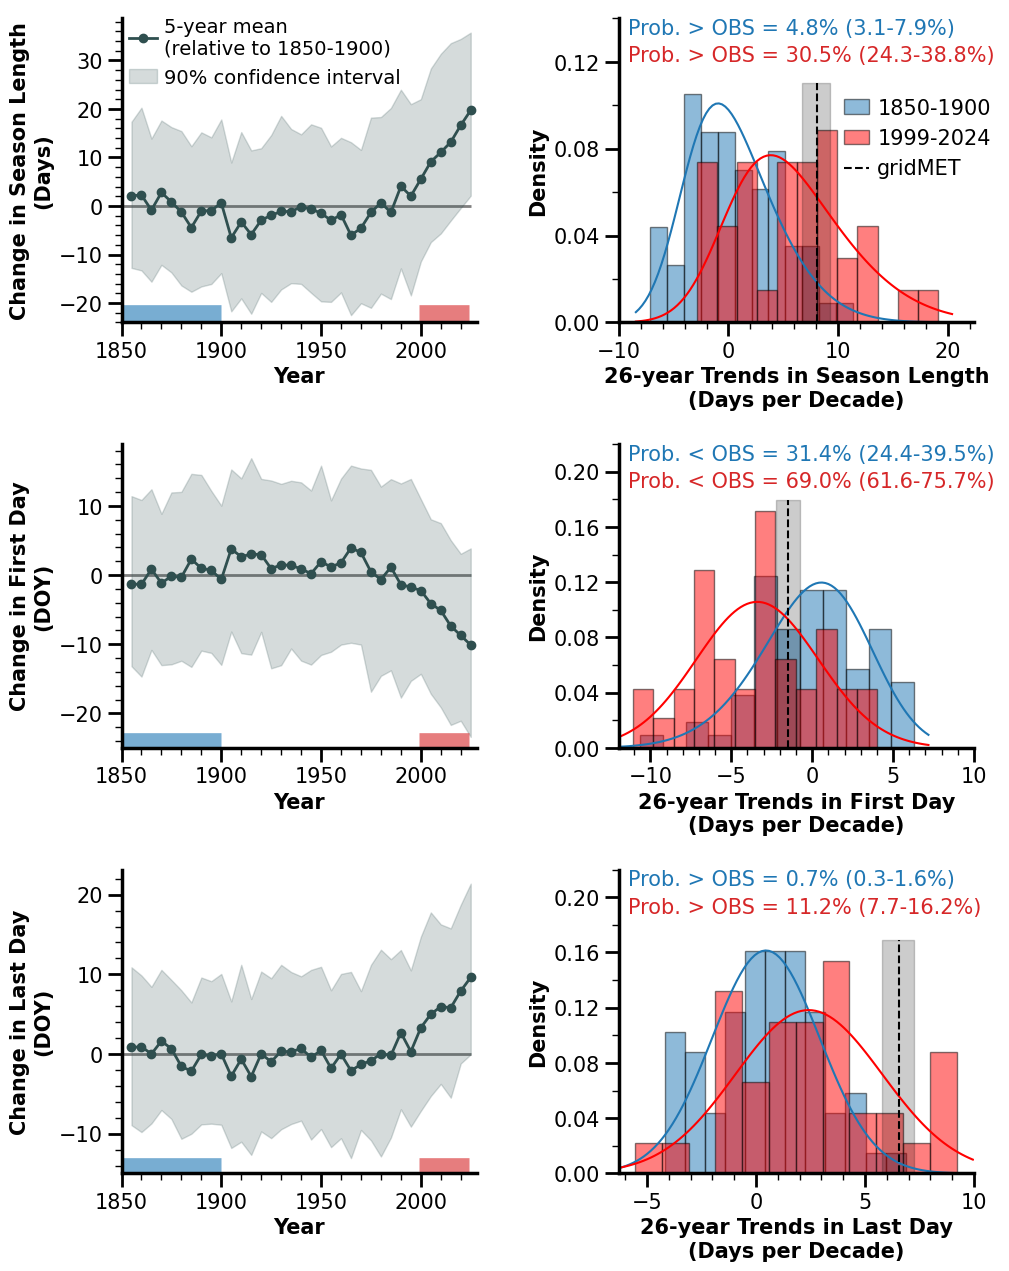

In [7]:
fig, axes = plt.subplots(3,2, figsize=[11,15], gridspec_kw={'hspace':0.4,'wspace':0.4})
ax3 = axes[:,0]
ax2 = axes[:,1]
prefix = '_'

num_boots = 1000

yr_idx = (WNV_SZN_BCSD_ds.year >= 2010) & (WNV_SZN_BCSD_ds.year <= 2024)
yr_idx_PI1 = (WNV_SZN_BCSD_ds.year >= 1850) & (WNV_SZN_BCSD_ds.year <= 1900)
title_list = ['season length', 'first DOY', 'last DOY']
varnames = ['szn_length', 'start_doy', 'end_doy']
ylabel_list = ['Season Length\n(Days)', 'First Day\n(DOY)', 'Last Day\n(DOY)']
scale_x = 1

gcm_slopes = {}
gcm_slopes_PI1, gcm_slopes_PI2 = {}, {}
for kk in range(3):
    print(kk)
    title = title_list[kk]
    varname = varnames[kk] 
    ylabel = ylabel_list[kk]
    gcm_slopes[varname] = []
    gcm_slopes_PI1[varname], gcm_slopes_PI2[varname] = [], []
    yy_gcm, yy_gcm_PI1, yy_gcm_diff = [], [], []

    decade_mean = np.ones([int(len(model_list)*len(WNV_SZN_BCSD_ds.county.values)),35])
    ct = 0
    ref_idx = WNV_SZN_BCSD_ds[varname].year <= 1900  
    annual_vals_all_counties = WNV_SZN_BCSD_ds[varname] - WNV_SZN_BCSD_ds[varname].sel(year=ref_idx).mean('year')  
    for model_jj, model in enumerate(model_list):
        for ii in range(len(WNV_SZN_BCSD_ds.county.values)):
            annual_vals = annual_vals_all_counties.sel(gcm=model).isel(county=ii)
            def get_decade_start(year):
                return ((year-1) // 5) * 5 + 5
            # Calculate the starting year of each time's decade
            decade_years = np.array([get_decade_start(yr) for yr in annual_vals.year])
            # Assign this as a new coordinate named 'decade'
            annual_vals = annual_vals.assign_coords(decade=('year', decade_years))
            # Calculate the mean value for each decade
            decade_mean[ct,:] = annual_vals.groupby('decade').mean(dim='year')[1:]
            decade_vals = np.unique(decade_years)[1:]

            ct = ct+1

    ax3[kk].plot(decade_vals,
             np.mean(decade_mean, axis=0), marker='o',
             color='darkslategray', alpha=1, lw=2, label='5-year mean\n(relative to 1850-1900)')
    ax3[kk].fill_between(x=decade_vals,
                     y1=np.quantile(decade_mean, axis=0, q=0.05), 
                     y2=np.quantile(decade_mean, axis=0, q=0.95),
                     color='darkslategray', alpha=0.2, label='90% confidence interval')
    
    ax3[kk].set_xlabel('Year', fontsize=15, fontweight='bold')
    ax3[kk].set_ylabel('Change in '+ylabel, fontsize=15, fontweight='bold')    
    ax3[kk].minorticks_on()
    ax3[kk].tick_params(axis='both',which='major',length=10,labelsize=15,width=2)    
    ax3[kk].tick_params(axis='both',which='minor',length=5,labelsize=10,width=1)
    ax3[kk].spines[['bottom', 'left']].set_linewidth(2.5)
    ax3[kk].spines[['top', 'right']].set_linewidth(0)
    ax3[kk].hlines(y=0, xmin=1850, xmax=2025, color='gray', lw=2, zorder=-99)
    
ax3[0].legend(fontsize=14, loc='upper left', borderaxespad=0, bbox_to_anchor=[0, 1.03], handletextpad=0.4, handlelength=1.4, frameon=False)

ax3[0].hlines(y=-22, xmin=1850, xmax=1900, color='tab:blue', lw=12, alpha=0.6)
ax3[0].hlines(y=-22, xmin=1999, xmax=2024, color='tab:red', lw=12, alpha=0.6)
ax3[0].set_ylim(bottom=-24)
ax3[1].hlines(y=-24, xmin=1850, xmax=1900, color='tab:blue', lw=12, alpha=0.6)
ax3[1].hlines(y=-24, xmin=1999, xmax=2024, color='tab:red', lw=12, alpha=0.6)
ax3[1].set_ylim(bottom=-25)
ax3[2].hlines(y=-14, xmin=1850, xmax=1900, color='tab:blue', lw=12, alpha=0.6)
ax3[2].hlines(y=-14, xmin=1999, xmax=2024, color='tab:red', lw=12, alpha=0.6)
ax3[2].set_ylim(bottom=-15)
for kk in range(3):
    ax3[kk].set_xlim(1850,2028)

####################################################################################

prefix = '_'

ax2_xticks = [[-10, 0, 10, 20], [-10, -5, 0, 5, 10], [-5, 0, 5, 10]]
ax2_minor_yticks = [[0.02, 0.06, 0.10, 0.14], [0.02, 0.06, 0.10, 0.14, 0.18, 0.22], [0.02, 0.06, 0.10, 0.14, 0.18, 0.22]]
ax2_yticks = [[0, 0.04, 0.08, 0.12], [0, 0.04, 0.08, 0.12, 0.16, 0.20], [0, 0.04, 0.08, 0.12, 0.16, 0.20]]

number_of_years = 26
yr_idx = (WNV_SZN_BCSD_ds.year >= 1999) & (WNV_SZN_BCSD_ds.year <= 2024)
yr_idx_gridMET = (WNV_SZN_gridMET_ds.year >= 1999) & (WNV_SZN_gridMET_ds.year <= 2024)
yr_idx_PI1 = (WNV_SZN_BCSD_ds.year >= 1850) & (WNV_SZN_BCSD_ds.year <= 1875)
yr_idx_PI2 = (WNV_SZN_BCSD_ds.year >= 1875) & (WNV_SZN_BCSD_ds.year <= 1900)

title_list = ['season length', 'first DOY', 'last DOY']
varnames = ['szn_length', 'start_doy', 'end_doy']
ylabel_list = ['Season Length (Days)', 'First Day (Days)', 'Last Day (Days)']
scale_x = 10

gcm_slopes = {}
gcm_slopes_PI1, gcm_slopes_PI2 = {}, {}
for kk in range(3):
    print(kk)
    title = title_list[kk]
    varname = varnames[kk] 
    ylabel = ylabel_list[kk]
    gcm_slopes[varname] = []
    gcm_slopes_PI1[varname], gcm_slopes_PI2[varname] = [], []
    ax_xx, ax_yy, ax_yy_PI = [], [], []
    for model in model_list:
        xx = WNV_SZN_BCSD_ds.sel(gcm=model)[varname].sel(year=yr_idx).year.values
        yy = WNV_SZN_BCSD_ds.sel(gcm=model)[varname].sel(year=yr_idx).values.T.flatten()
        xx_PI1 = WNV_SZN_BCSD_ds.sel(gcm=model)[varname].sel(year=yr_idx_PI1).year.values
        yy_PI1 = WNV_SZN_BCSD_ds.sel(gcm=model)[varname].sel(year=yr_idx_PI1).values.T.flatten()
        xx_PI2 = WNV_SZN_BCSD_ds.sel(gcm=model)[varname].sel(year=yr_idx_PI2).year.values
        yy_PI2 = WNV_SZN_BCSD_ds.sel(gcm=model)[varname].sel(year=yr_idx_PI2).values.T.flatten()
        
        xx = np.tile(xx,[len(WNV_SZN_BCSD_ds.sel(gcm=model)[varname].county)])        
        xx_PI1 = np.tile(xx_PI1,[len(WNV_SZN_BCSD_ds.sel(gcm=model)[varname].county)])        
        xx_PI2 = np.tile(xx_PI2,[len(WNV_SZN_BCSD_ds.sel(gcm=model)[varname].county)])     
        
        np.random.seed([11, 11])
        for nboot in range(num_boots):
            boot_idx = np.random.choice(range(len(yy)), size=len(yy), replace=True)
            boot_idx_PI1 = np.random.choice(range(len(yy_PI1)), size=len(yy_PI1), replace=True)
            boot_idx_PI2 = np.random.choice(range(len(yy_PI2)), size=len(yy_PI2), replace=True)

            xx_boot, yy_boot = xx[boot_idx], yy[boot_idx]
            xx_PI1_boot, yy_PI1_boot = xx_PI1[boot_idx_PI1], yy_PI1[boot_idx_PI1]
            xx_PI2_boot, yy_PI2_boot = xx_PI2[boot_idx_PI2], yy_PI2[boot_idx_PI2]

            coeffs = np.polyfit(xx, yy, deg=1)
            coeffs_PI1 = np.polyfit(xx_PI1, yy_PI1, deg=1)
            coeffs_PI2 = np.polyfit(xx_PI2, yy_PI2, deg=1)
            
            gcm_slopes[varname].append(coeffs[0])
            gcm_slopes_PI1[varname].append(coeffs_PI1[0])
            gcm_slopes_PI2[varname].append(coeffs_PI2[0])

            ax_xx.append(np.arange(1,number_of_years+1))
            ax_yy.append(np.polyval(coeffs, np.unique(xx)).reshape([1,-1]))
            ax_yy_PI.append(np.polyval(coeffs_PI1, np.unique(xx_PI1)).reshape([1,-1]))
            ax_yy_PI.append(np.polyval(coeffs_PI2, np.unique(xx_PI2)).reshape([1,-1]))
        
    ax_xx = ax_xx[-1]

    ax2[kk].hist(scale_x*np.concat([gcm_slopes_PI1[varname], gcm_slopes_PI2[varname]]), histtype='bar', zorder=-99,
                 bins=12, density=True, alpha=0.5, linewidth=1,
                 color='tab:blue', edgecolor='k', label='1850-1900')
    ax2[kk].hist(scale_x*np.array(gcm_slopes[varname]), color='red', histtype='bar', edgecolor='k',
                 bins=12, density=True, alpha=0.5, linewidth=1,
                 label=''+str(2024-number_of_years+1)+'-2024')
    
    
    ####################
    ## add gamma PDFs ##
    ####################
    
    xmin, xmax = ax2[kk].get_xlim()
    xx = np.linspace(xmin, xmax, 100)
    
    PI_data = scale_x*np.concat([gcm_slopes_PI1[varname], gcm_slopes_PI2[varname]])
    PI_shape, PI_loc, PI_scale = stats.skewnorm.fit(PI_data)
    PI_pdf_fitted = stats.skewnorm.pdf(xx, a=PI_shape, loc=PI_loc, scale=PI_scale)
    ax2[kk].plot(xx, PI_pdf_fitted, color='tab:blue')
    
    hist_data = scale_x*np.array(gcm_slopes[varname])
    hist_shape, hist_loc, hist_scale = stats.skewnorm.fit(hist_data)
    hist_pdf_fitted = stats.skewnorm.pdf(xx, a=hist_shape, loc=hist_loc, scale=hist_scale)
    ax2[kk].plot(xx, hist_pdf_fitted, color='red')
    ax2[kk].set_xlim(xmin, xmax)

    ###########################
    ## plot gridMET boxplots ##
    ###########################

    for pp, yr in enumerate(WNV_SZN_gridMET_ds[varname].year.values[yr_idx_gridMET.values]):
        ymed = np.mean(WNV_SZN_gridMET_ds[varname].sel(year=yr))
        yerr = np.std(WNV_SZN_gridMET_ds[varname].sel(year=yr))
        
    ##############################
    ## plot gridMET linear fits ##
    ##############################

    ymin, ymax = ax2[kk].get_ylim()
    ymax = ymax*1.2    
    slope_list = []
    prefix = '_'
    gridmet_xx, gridmet_yy = [], []
    
    ds = WNV_SZN_gridMET_ds[varname]
    xx, yy = ds.year.values[yr_idx_gridMET.values], ds.values.T.flatten()
    xx = np.tile(xx,[len(ds.county)])        

    np.random.seed([11, 11])
    for nboot in range(num_boots):
        boot_idx = np.random.choice(range(len(yy)), size=len(yy), replace=True)
        xx_boot, yy_boot = xx[boot_idx], yy[boot_idx]
        coeffs = np.polyfit(xx_boot, yy_boot, deg=1)

        gridmet_xx.append(np.arange(1,number_of_years+1))
        gridmet_yy.append(np.polyval(coeffs, np.unique(WNV_SZN_gridMET_ds[varname].year.values)).reshape([1,-1]))
        slope_list.append(coeffs[0])
        prefix = '_'

    gridmet_xx = gridmet_xx[-1]
    gridmet_yy_med = np.median(np.concatenate(gridmet_yy, axis=0), axis=0)
    gridmet_yy_max = np.quantile(np.concatenate(gridmet_yy, axis=0), axis=0, q=0.95)
    gridmet_yy_min = np.quantile(np.concatenate(gridmet_yy, axis=0), axis=0, q=0.05)
    
    print(varname, np.quantile(slope_list, q=0.50))
    slope_list = np.array(slope_list)
    
    
    if kk>=0:
        ax2[kk].vlines(x=scale_x*np.quantile(slope_list, q=0.50), ymin=ymin, ymax=ymax*0.83, 
                   ls='dashed', color='k', label='gridMET')
        ax2[kk].fill_betweenx(x1=[scale_x*np.quantile(slope_list, q=0.05), scale_x*np.quantile(slope_list, q=0.05)], 
                          x2=[scale_x*np.quantile(slope_list, q=0.95), scale_x*np.quantile(slope_list, q=0.95)], 
                          y = [ymin, ymax*0.83], color='k', alpha=0.2)
    else:
        ax2[kk].vlines(x=scale_x*np.quantile(slope_list, q=0.50), ymin=ymin, ymax=ymax, 
                   ls='dashed', color='k', label='gridMET')
        ax2[kk].fill_betweenx(x1=[scale_x*np.quantile(slope_list, q=0.05), scale_x*np.quantile(slope_list, q=0.05)], 
                              x2=[scale_x*np.quantile(slope_list, q=0.95), scale_x*np.quantile(slope_list, q=0.95)], 
                              y = [ymin, ymax], color='k', alpha=0.2)
        
    gridMET_min = scale_x*np.quantile(slope_list, q=0.05)
    gridMET_med = scale_x*np.quantile(slope_list, q=0.5)
    gridMET_max = scale_x*np.quantile(slope_list, q=0.95)

    def get_perc_str(perc):
        return str(np.round(perc,1))
        
    if varname=='start_doy':
        PI_min_prob = get_perc_str(100*np.round(stats.skewnorm.cdf(gridMET_min, a=PI_shape, loc=PI_loc, scale=PI_scale),3))
        PI_med_prob = get_perc_str(100*np.round(stats.skewnorm.cdf(gridMET_med, a=PI_shape, loc=PI_loc, scale=PI_scale),3))
        PI_max_prob = get_perc_str(100*np.round(stats.skewnorm.cdf(gridMET_max, a=PI_shape, loc=PI_loc, scale=PI_scale),3))
        hist_min_prob = get_perc_str(100*np.round(stats.skewnorm.cdf(gridMET_min, a=hist_shape, loc=hist_loc, scale=hist_scale),3))
        hist_med_prob = get_perc_str(100*np.round(stats.skewnorm.cdf(gridMET_med, a=hist_shape, loc=hist_loc, scale=hist_scale),3))
        hist_max_prob = get_perc_str(100*np.round(stats.skewnorm.cdf(gridMET_max, a=hist_shape, loc=hist_loc, scale=hist_scale),3))
    else:
        PI_min_prob = get_perc_str(100*np.round(stats.skewnorm.sf(gridMET_min, a=PI_shape, loc=PI_loc, scale=PI_scale),3))
        PI_med_prob = get_perc_str(100*np.round(stats.skewnorm.sf(gridMET_med, a=PI_shape, loc=PI_loc, scale=PI_scale),3))
        PI_max_prob = get_perc_str(100*np.round(stats.skewnorm.sf(gridMET_max, a=PI_shape, loc=PI_loc, scale=PI_scale),3))
        hist_min_prob = get_perc_str(100*np.round(stats.skewnorm.sf(gridMET_min, a=hist_shape, loc=hist_loc, scale=hist_scale),3))
        hist_med_prob = get_perc_str(100*np.round(stats.skewnorm.sf(gridMET_med, a=hist_shape, loc=hist_loc, scale=hist_scale),3))
        hist_max_prob = get_perc_str(100*np.round(stats.skewnorm.sf(gridMET_max, a=hist_shape, loc=hist_loc, scale=hist_scale),3))

        PI_min_prob, PI_med_prob, PI_max_prob = PI_max_prob, PI_med_prob, PI_min_prob
        hist_min_prob, hist_med_prob, hist_max_prob = hist_max_prob, hist_med_prob, hist_min_prob

    print(varname, PI_min_prob, PI_med_prob, PI_max_prob)

    if kk==1:
        ineq = ' < '
    else:
        ineq = ' > '
        
    if PI_max_prob == '< 1':
        ax2[kk].annotate('Prob.'+ineq+'OBS = '+PI_max_prob+'%',
                     fontsize=15, xycoords='axes fraction', xy=[0.025, 1.00], ha='left', va='top', color='tab:blue')
    else:
        ax2[kk].annotate('Prob.'+ineq+'OBS = '+PI_med_prob+'% ('+PI_min_prob+'-'+PI_max_prob+'%)',
                     fontsize=15, xycoords='axes fraction', xy=[0.025, 1.00], ha='left', va='top', color='tab:blue')
    ax2[kk].annotate('Prob.'+ineq+'OBS = '+hist_med_prob+'% ('+hist_min_prob+'-'+hist_max_prob+'%)',
                 fontsize=15, xycoords='axes fraction', xy=[0.025, 0.91], ha='left', va='top', color='tab:red')

    ax2[kk].set_ylim(ymin, ymax)
    ax2[kk].set_ylabel('Density', fontsize=15, fontweight='bold')

    ax2[kk].set_xticks(ax2_xticks[kk])
    ax2[kk].set_yticks(ax2_yticks[kk])
    ax2[kk].minorticks_on()
    ax2[kk].set_yticks(ax2_minor_yticks[kk], minor=True)
    
    ax2[kk].tick_params(axis='both',which='major',length=10,labelsize=15,width=2)    
    ax2[kk].tick_params(axis='both',which='minor',length=5,labelsize=10,width=1)

    ax2[kk].spines[['bottom', 'left']].set_linewidth(2.5)
    ax2[kk].spines[['top', 'right']].set_linewidth(0)

ax2[0].set_xlabel('26-year Trends in Season Length\n(Days per Decade)', fontsize=15, fontweight='bold')
ax2[1].set_xlabel('26-year Trends in First Day\n(Days per Decade)', fontsize=15, fontweight='bold')
ax2[2].set_xlabel('26-year Trends in Last Day\n(Days per Decade)', fontsize=15, fontweight='bold')

ax2[0].legend(fontsize=15, handlelength=1.2, handletextpad=0.4, frameon=False, loc='upper right', bbox_to_anchor=[1.10,0.8])
ax2[0].set_xlim(right=ax2[0].get_xlim()[1]+2)
ax2[0].set_ylim(top=0.14)
ax2[2].set_ylim(top=0.22)

plt.savefig('../figures/Fig_5.jpg', dpi=500, bbox_inches='tight', pad_inches=0.2)
plt.savefig('../figures/Fig_5.pdf', dpi=500, bbox_inches='tight', pad_inches=0.2)

# Supplemental Figure 4

0 p= 7.981273571409224e-205
1 p= 7.157370058215914e-200
2 p= 2.0094404581001887e-149


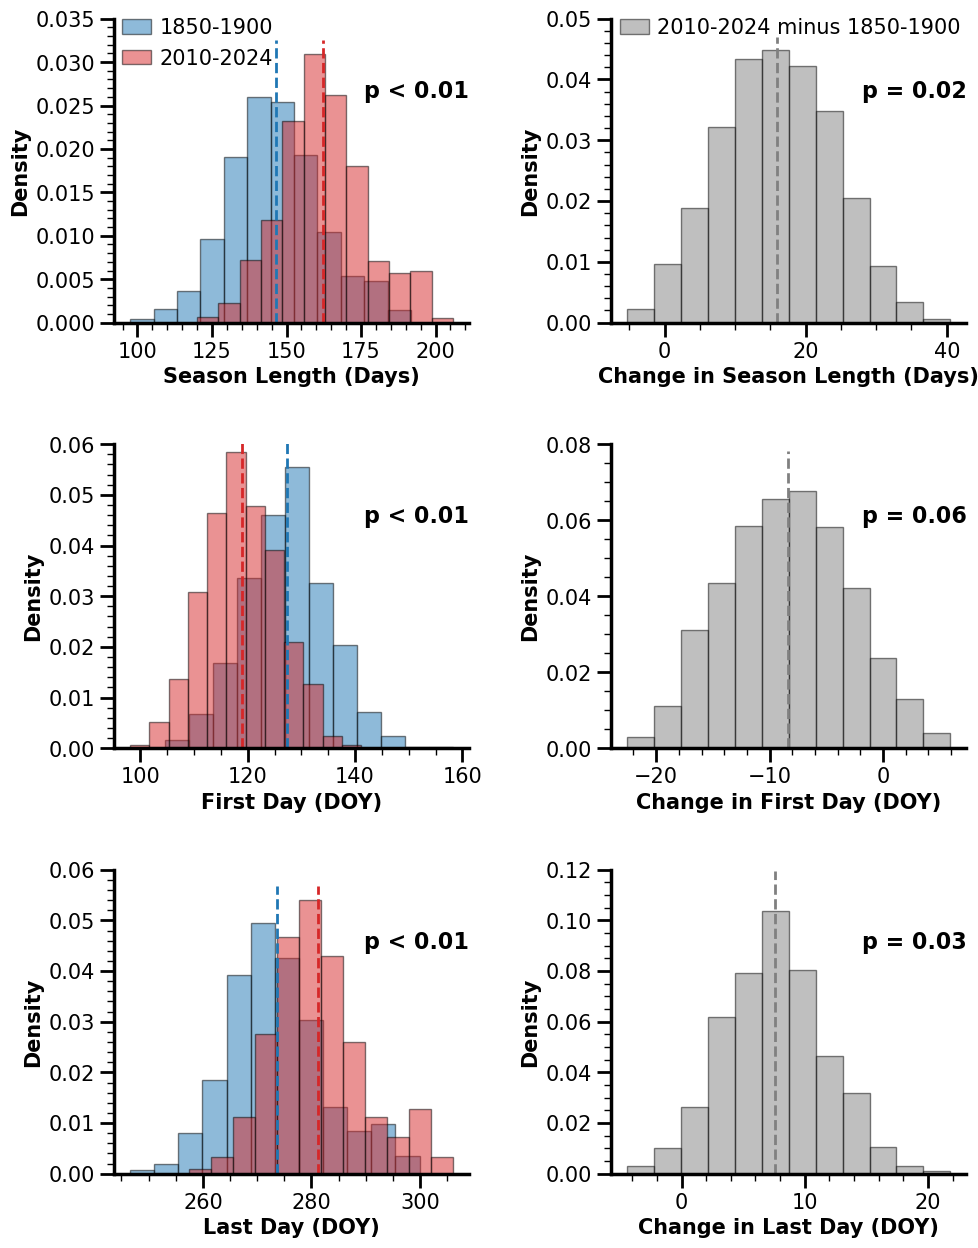

In [106]:
fig, axes = plt.subplots(3,2, figsize=[11,15], gridspec_kw={'hspace':0.4,'wspace':0.4})
ax = axes[:,0]
ax2 = axes[:,1]
#######################################
prefix = '_'

yr_idx = (WNV_SZN_BCSD_ds.year >= 2010) & (WNV_SZN_BCSD_ds.year <= 2024)
yr_idx_PI1 = (WNV_SZN_BCSD_ds.year >= 1850) & (WNV_SZN_BCSD_ds.year <= 1900)
title_list = ['season length', 'first DOY', 'last DOY']
varnames = ['szn_length', 'start_doy', 'end_doy']
ylabel_list = ['Season Length (Days)', 'First Day (DOY)', 'Last Day (DOY)']
scale_x = 1

gcm_slopes = {}
gcm_slopes_PI1, gcm_slopes_PI2 = {}, {}
for kk in range(3):
    title = title_list[kk]
    varname = varnames[kk] 
    ylabel = ylabel_list[kk]
    gcm_slopes[varname] = []
    gcm_slopes_PI1[varname], gcm_slopes_PI2[varname] = [], []
    yy_gcm, yy_gcm_PI1, yy_gcm_diff = [], [], []

    decadal_rolling_mean = np.ones([int(len(model_list)*len(WNV_SZN_BCSD_ds.county.values)),len(WNV_SZN_BCSD_ds.year.values)])
    ct = 0
    for model in model_list:
        yy = []
        yy_PI1, yy_diff = [], []
        for ii in range(len(WNV_SZN_BCSD_ds.county.values)):
            yy.append(np.mean(WNV_SZN_BCSD_ds.sel(gcm=model)[varname][:,ii].values[yr_idx.values]))
            yy_PI1.append(np.mean(WNV_SZN_BCSD_ds.sel(gcm=model)[varname][:,ii].values[yr_idx_PI1.values]))
            yy_diff.append(np.mean(WNV_SZN_BCSD_ds.sel(gcm=model)[varname][:,ii].values[yr_idx.values]) - 
                           np.mean(WNV_SZN_BCSD_ds.sel(gcm=model)[varname][:,ii].values[yr_idx_PI1.values]))

            ref_idx = WNV_SZN_BCSD_ds[varname].year <= 1900
            annual_vals = WNV_SZN_BCSD_ds[varname].sel(gcm=model).isel(county=ii) - WNV_SZN_BCSD_ds[varname].sel(year=ref_idx, gcm=model).isel(county=ii).mean('year')            
            decadal_rolling_mean[ct,:] = pd.Series(annual_vals).rolling(10).mean().values.reshape([1,-1])
            ct = ct+1
            
        # yy_gcm.append(np.mean(yy))
        # yy_gcm_PI1.append(np.mean(yy_PI1))
        # yy_gcm_diff.append(np.mean(yy_diff))
        yy_gcm.append(yy)
        yy_gcm_PI1.append(yy_PI1)
        yy_gcm_diff.append(yy_diff)

    yy_gcm = np.array(yy_gcm).flatten()
    yy_gcm_PI1 = np.array(yy_gcm_PI1).flatten()
    yy_gcm_diff = np.array(yy_gcm_diff).flatten()
    
    ax[kk].hist(yy_gcm_PI1, color='tab:blue', edgecolor='k', bins=12,
                 density=True, alpha=0.5, linewidth=1, label='1850-1900')
    ax[kk].hist(yy_gcm, color='tab:red', edgecolor='k', bins=12,
                 density=True, alpha=0.5, linewidth=1, label='2010-2024')
    ax[kk].vlines(x=np.mean(yy_gcm_PI1), ymin=0, ymax=ax[kk].set_ylim()[1], lw=2, ls='dashed', color='tab:blue')
    ax[kk].vlines(x=np.mean(yy_gcm), ymin=0, ymax=ax[kk].set_ylim()[1], lw=2, ls='dashed', color='tab:red')
    
    print(kk, 'p=',ks_2samp(yy_gcm_PI1, yy_gcm).pvalue)
    if ks_2samp(yy_gcm_PI1, yy_gcm).pvalue < 0.01:
        ax[kk].annotate('p < 0.01', fontsize=16, fontweight='bold', xy=[1.0,0.8], xycoords='axes fraction', va='top', ha='right')
    
    ax2[kk].hist(yy_gcm_diff, color='gray', edgecolor='k', bins=12,
                 density=True, alpha=0.5, linewidth=1, label='2010-2024 minus 1850-1900')
    
    ax2[kk].vlines(x=np.mean(yy_gcm_diff), ymin=0, ymax=ax2[kk].set_ylim()[1]*(1+0.1*int(kk>0)), lw=2, ls='dashed', color='gray')

    if kk==1:
        ax2_pval = sum(yy_gcm_diff > 0) / len(yy_gcm_diff)
    else:
        ax2_pval = sum(yy_gcm_diff < 0) / len(yy_gcm_diff)
        
    if ax2_pval < 0.01:
        ax2[kk].annotate('p < 0.01', fontsize=16, fontweight='bold', xy=[1.0,0.8], xycoords='axes fraction', va='top', ha='right')
    else:
        ax2[kk].annotate('p = '+str(np.round(ax2_pval,2)), fontsize=16, fontweight='bold', xy=[1.0,0.8], xycoords='axes fraction', va='top', ha='right')
    
    ax2[kk].set_ylabel('Density', fontsize=15, fontweight='bold')
    ax2[kk].set_xlabel('Change in '+ylabel, fontsize=15, fontweight='bold')    

    ax[kk].set_ylabel('Density', fontsize=15, fontweight='bold')
    ax[kk].set_xlabel(ylabel, fontsize=15, fontweight='bold')    

    ax[kk].minorticks_on()
    ax2[kk].minorticks_on()
    
    ax[kk].tick_params(axis='both',which='major',length=10,labelsize=15,width=2)    
    ax[kk].tick_params(axis='both',which='minor',length=5,labelsize=10,width=1)
    ax2[kk].tick_params(axis='both',which='major',length=10,labelsize=15,width=2)    
    ax2[kk].tick_params(axis='both',which='minor',length=5,labelsize=10,width=1)

    ax[kk].spines[['bottom', 'left']].set_linewidth(2.5)
    ax[kk].spines[['top', 'right']].set_linewidth(0)
    ax2[kk].spines[['bottom', 'left']].set_linewidth(2.5)
    ax2[kk].spines[['top', 'right']].set_linewidth(0)

ax[0].legend(fontsize=15, loc='upper left', borderaxespad=0, bbox_to_anchor=[0, 1.03], handletextpad=0.4, handlelength=1.4, frameon=False)
ax2[0].legend(fontsize=15, loc='upper left', borderaxespad=0, bbox_to_anchor=[0, 1.03], handletextpad=0.4, handlelength=1.4, frameon=False)

ax[0].set_ylim(top=0.035)
ax[1].set_ylim(top=0.060)
ax[2].set_ylim(top=0.060)

ax2[0].set_ylim(top=0.05)
ax2[1].set_ylim(top=0.08)
ax2[2].set_ylim(top=0.12)

plt.savefig('../figures/Supfig_4.jpg', dpi=500, bbox_inches='tight', pad_inches=0.2)
plt.savefig('../figures/Supfig_4.pdf', dpi=500, bbox_inches='tight', pad_inches=0.2)

# Supplemental Figure 5

szn_length 0.8057596726460337
start_doy -0.15084903725090937
end_doy 0.6543809208602589


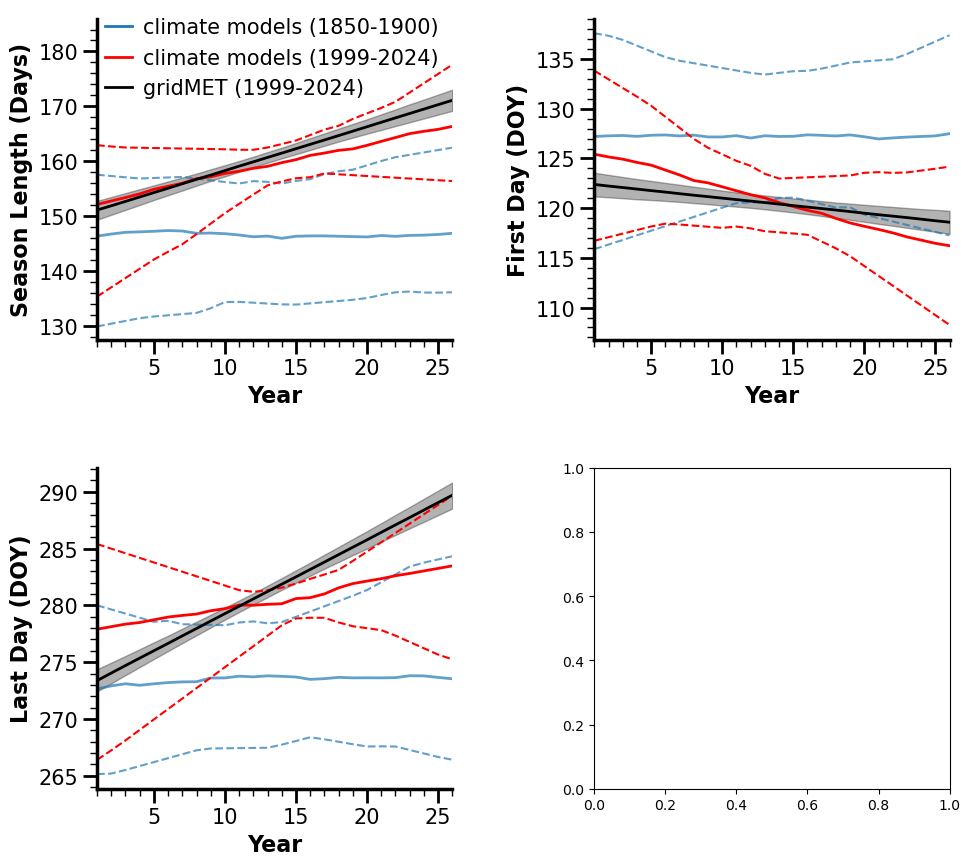

In [107]:
fig, axes = plt.subplots(2,2, figsize=[11,10], gridspec_kw={'hspace':0.4,'wspace':0.4})
ax = axes.flatten()
# ax2 = axes[:,1]
#######################################
prefix = '_'
num_boots = 1000

ax2_xticks = [[-10, 0, 10, 20], [-10, -5, 0, 5, 10], [-5, 0, 5, 10]]
ax2_minor_yticks = [[0.01, 0.03, 0.05, 0.07, 0.09, 0.11, 0.13], [0.01, 0.03, 0.05, 0.07, 0.09, 0.11, 0.13, 0.15, 0.17], [0.02, 0.06, 0.10, 0.14, 0.18, 0.22, 0.26]]
ax2_yticks = [[0, 0.02, 0.04, 0.06, 0.08, 0.10, 0.12], [0, 0.02, 0.04, 0.06, 0.08, 0.10, 0.12, 0.14, 0.16, 0.18], [0, 0.04, 0.08, 0.12, 0.16, 0.20, 0.24]]

number_of_years = 26
yr_idx = (WNV_SZN_BCSD_ds.year >= 1999) & (WNV_SZN_BCSD_ds.year <= 2024)
yr_idx_gridMET = (WNV_SZN_gridMET_ds.year >= 1999) & (WNV_SZN_gridMET_ds.year <= 2024)
yr_idx_PI1 = (WNV_SZN_BCSD_ds.year >= 1850) & (WNV_SZN_BCSD_ds.year <= 1875)
yr_idx_PI2 = (WNV_SZN_BCSD_ds.year >= 1875) & (WNV_SZN_BCSD_ds.year <= 1900)

title_list = ['season length', 'first DOY', 'last DOY']
varnames = ['szn_length', 'start_doy', 'end_doy']
ylabel_list = ['Season Length (Days)', 'First Day (DOY)', 'Last Day (DOY)']
scale_x = 10

gcm_slopes = {}
gcm_slopes_PI1, gcm_slopes_PI2 = {}, {}
for kk in range(3):
    title = title_list[kk]
    varname = varnames[kk] 
    ylabel = ylabel_list[kk]
    gcm_slopes[varname] = []
    gcm_slopes_PI1[varname], gcm_slopes_PI2[varname] = [], []
    ax_xx, ax_yy, ax_yy_PI = [], [], []    
    
    for model in model_list:
        xx = WNV_SZN_BCSD_ds.sel(gcm=model)[varname].sel(year=yr_idx).year.values
        yy = WNV_SZN_BCSD_ds.sel(gcm=model)[varname].sel(year=yr_idx).values.T.flatten()
        xx_PI1 = WNV_SZN_BCSD_ds.sel(gcm=model)[varname].sel(year=yr_idx_PI1).year.values
        yy_PI1 = WNV_SZN_BCSD_ds.sel(gcm=model)[varname].sel(year=yr_idx_PI1).values.T.flatten()
        xx_PI2 = WNV_SZN_BCSD_ds.sel(gcm=model)[varname].sel(year=yr_idx_PI2).year.values
        yy_PI2 = WNV_SZN_BCSD_ds.sel(gcm=model)[varname].sel(year=yr_idx_PI2).values.T.flatten()
        
        xx = np.tile(xx,[len(WNV_SZN_BCSD_ds.sel(gcm=model)[varname].county)])        
        xx_PI1 = np.tile(xx_PI1,[len(WNV_SZN_BCSD_ds.sel(gcm=model)[varname].county)])        
        xx_PI2 = np.tile(xx_PI2,[len(WNV_SZN_BCSD_ds.sel(gcm=model)[varname].county)])     
        
        np.random.seed([11, 11])
        for nboot in range(num_boots):
            boot_idx = np.random.choice(range(len(yy)), size=len(yy), replace=True)
            boot_idx_PI1 = np.random.choice(range(len(yy_PI1)), size=len(yy_PI1), replace=True)
            boot_idx_PI2 = np.random.choice(range(len(yy_PI2)), size=len(yy_PI2), replace=True)

            xx_boot, yy_boot = xx[boot_idx], yy[boot_idx]
            xx_PI1_boot, yy_PI1_boot = xx_PI1[boot_idx_PI1], yy_PI1[boot_idx_PI1]
            xx_PI2_boot, yy_PI2_boot = xx_PI2[boot_idx_PI2], yy_PI2[boot_idx_PI2]

            coeffs = np.polyfit(xx, yy, deg=1)
            coeffs_PI1 = np.polyfit(xx_PI1, yy_PI1, deg=1)
            coeffs_PI2 = np.polyfit(xx_PI2, yy_PI2, deg=1)
            
            gcm_slopes[varname].append(coeffs[0])
            gcm_slopes_PI1[varname].append(coeffs_PI1[0])
            gcm_slopes_PI2[varname].append(coeffs_PI2[0])

            ax_xx.append(np.arange(1,number_of_years+1))
            ax_yy.append(np.polyval(coeffs, np.unique(xx)).reshape([1,-1]))
            ax_yy_PI.append(np.polyval(coeffs_PI1, np.unique(xx_PI1)).reshape([1,-1]))
            ax_yy_PI.append(np.polyval(coeffs_PI2, np.unique(xx_PI2)).reshape([1,-1]))

    ax_xx = ax_xx[-1]
    ax[kk].plot(ax_xx, np.quantile(np.concatenate(ax_yy_PI, axis=0), axis=0, q=0.5), color='tab:blue', alpha=0.7, lw=2, label='_range of individual GCMs\n(1850-1901)')
    ax[kk].plot(ax_xx, np.quantile(np.concatenate(ax_yy_PI, axis=0), axis=0, q=0.05), color='tab:blue', alpha=0.7, ls='dashed', lw=1.5, label='_range of individual GCMs\n(1850-1901)')
    ax[kk].plot(ax_xx, np.quantile(np.concatenate(ax_yy_PI, axis=0), axis=0, q=0.95), color='tab:blue', alpha=0.7, ls='dashed', lw=1.5, label='_range of individual GCMs\n(1850-1901)')
    ax[kk].plot(ax_xx, np.quantile(np.concatenate(ax_yy, axis=0), axis=0, q=0.5), color='red', lw=2, label='_range of individual GCMs\n(1999-2024)')
    ax[kk].plot(ax_xx, np.quantile(np.concatenate(ax_yy, axis=0), axis=0, q=0.95), color='red', ls='dashed', lw=1.5, label='_range of individual GCMs\n(1999-2024)')
    ax[kk].plot(ax_xx, np.quantile(np.concatenate(ax_yy, axis=0), axis=0, q=0.05), color='red', ls='dashed', lw=1.5, label='_range of individual GCMs\n(1999-2024)')
    ax[kk].set_xlim(min(ax_xx), max(ax_xx))
    
    ###########################
    ## plot gridMET boxplots ##
    ###########################

    for pp, yr in enumerate(WNV_SZN_gridMET_ds[varname].year.values[yr_idx_gridMET.values]):
        ymed = np.mean(WNV_SZN_gridMET_ds[varname].sel(year=yr))
        yerr = np.std(WNV_SZN_gridMET_ds[varname].sel(year=yr))
        
    ##############################
    ## plot gridMET linear fits ##
    ##############################

    slope_list = []
    prefix = '_'
    gridmet_xx, gridmet_yy = [], []

    ds = WNV_SZN_gridMET_ds[varname]
    xx, yy = ds.year.values[yr_idx_gridMET.values], ds.values.T.flatten()
    xx = np.tile(xx,[len(ds.county)])        

    np.random.seed([11, 11])
    for nboot in range(num_boots):
        boot_idx = np.random.choice(range(len(yy)), size=len(yy), replace=True)
        xx_boot, yy_boot = xx[boot_idx], yy[boot_idx]
        coeffs = np.polyfit(xx_boot, yy_boot, deg=1)

        gridmet_xx.append(np.arange(1,number_of_years+1))
        gridmet_yy.append(np.polyval(coeffs, np.unique(WNV_SZN_gridMET_ds[varname].year.values)).reshape([1,-1]))
        slope_list.append(coeffs[0])
        prefix = '_'

    gridmet_xx = gridmet_xx[-1]
    gridmet_yy_med = np.median(np.concatenate(gridmet_yy, axis=0), axis=0)
    gridmet_yy_max = np.quantile(np.concatenate(gridmet_yy, axis=0), axis=0, q=0.95)
    gridmet_yy_min = np.quantile(np.concatenate(gridmet_yy, axis=0), axis=0, q=0.05)
    ax[kk].plot(gridmet_xx, gridmet_yy_med, color='k', lw=2)
    ax[kk].fill_between(x=gridmet_xx, y1=gridmet_yy_min, y2=gridmet_yy_max, color='k', alpha=0.3)
    ax[kk].set_xlim(min(gridmet_xx), max(gridmet_xx))

    print(varname, np.quantile(slope_list, q=0.50))
    slope_list = np.array(slope_list)
        
    gridMET_min = scale_x*np.quantile(slope_list, q=0.05)
    gridMET_med = scale_x*np.quantile(slope_list, q=0.5)
    gridMET_max = scale_x*np.quantile(slope_list, q=0.95)

    def get_perc_str(perc):
        return str(np.round(perc,1))
        
    if kk==1:
        ineq = ' < '
    else:
        ineq = ' > '

    # ax[kk].set_title(''+title, fontsize=19)
    ax[kk].set_xlabel('Year', fontsize=16, fontweight='bold')
    ax[kk].set_ylabel(ylabel, fontsize=16, fontweight='bold')    
    ax[kk].set_xlim(min(gridmet_xx), max(gridmet_xx))
    

    ## make labels for legend ##
    ymin, ymax = ax[kk].get_ylim()
    ax[kk].plot([-10,-9],[0,1], lw=2, color='tab:blue', label='climate models (1850-1900)')
    ax[kk].plot([-10,-9],[0,1], lw=2, color='red', label='climate models ('+str(2024-number_of_years+1)+'-2024)')
    ax[kk].plot([-10,-9],[0,1], lw=2, color='k', label='gridMET (1999-2024)')
    ax[kk].set_ylim(ymin, ymax)

    ax[kk].set_xticks([5, 10, 15, 20, 25])
    # ax[kk].set_yticks(ax_yticks[kk])
    ax[kk].minorticks_on()
    # ax[kk].set_xticks([2.5, 7.5, 12.5, 17.5, 22.5], minor=True)

    ax[kk].tick_params(axis='both',which='major',length=10,labelsize=15,width=2)    
    ax[kk].tick_params(axis='both',which='minor',length=5,labelsize=10,width=1)

    ax[kk].spines[['bottom', 'left']].set_linewidth(2.5)
    ax[kk].spines[['top', 'right']].set_linewidth(0)

ax[0].legend(ncol=1, fontsize=15, loc='upper left', handlelength=1.3, bbox_to_anchor=[0.0, 1.03], handletextpad=0.5, frameon=False, borderaxespad=0)
ax[0].set_ylim(ax[0].get_ylim()[0], ax[0].get_ylim()[1]+6)

# fig.suptitle('Comparing observed trends in WNV season characteristics\nwith 26-year trends from climate model simulations', fontsize=20, fontweight='bold')
# plt.tight_layout()
plt.savefig('../figures/Supfig_5.jpg', dpi=500, bbox_inches='tight', pad_inches=0.2)
plt.savefig('../figures/Supfig_5.pdf', dpi=500, bbox_inches='tight', pad_inches=0.2)